In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import requests
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time
import struct

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t,60)
    h, m = divmod(m,60)
    return f'{int(h):02d}:{int(m):02d}:{s:05.2f}'

#### Get NASDAQ data from FTP Server

The Nasdaq offers [samples](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/) of daily binary files for several months. 

| Name                    | Offset  | Length  | Value      | Notes                                                                                |
|-------------------------|---------|---------|------------|--------------------------------------------------------------------------------------|
| Message Type            | 0       | 1       | S          | System Event Message                                                                 |
| Stock Locate            | 1       | 2       | Integer    | Always 0                                                                             |
| Tracking Number         | 3       | 2       | Integer    | Nasdaq internal tracking number                                                      |
| Timestamp               | 5       | 6       | Integer    | Nanoseconds since midnight                                                           |
| Order Reference Number  | 11      | 8       | Integer    | The unique reference number assigned to the new order at the time of receipt.        |
| Buy/Sell Indicator      | 19      | 1       | Alpha      | The type of order being added. B = Buy Order. S = Sell Order.                        |
| Shares                  | 20      | 4       | Integer    | The total number of shares associated with the order being added to the book.        |
| Stock                   | 24      | 8       | Alpha      | Stock symbol, right padded with spaces                                               |
| Price                   | 32      | 4       | Price (4)  | The display price of the new order. Refer to Data Types for field processing notes.  |
| Attribution             | 36      | 4       | Alpha      | Nasdaq Market participant identifier associated with the entered order               |

#### Set Data Path

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [4]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [5]:
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/'
SOURCE_FILE = '12302019.NASDAQ_ITCH50.gz'

#### URL updates

NASDAQ updates the files occasionally so that the SOURCE_FILE changes. If the above gives an error, navigate to the HTTPS_URL using your browser, and check for new files.

#### Download and Unzip

In [6]:
def may_be_download(url, data_path):
    """Download & unzip ITCH data if not yet available"""
    data_path = Path(data_path)
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir(parents=True, exist_ok=True)
    else: 
        print('Directory exists')

    filename = data_path / url.split('/')[-1]        
    if not filename.exists():
        print('Downloading...', url)
        # Using requests to download in chunks
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    else: 
        print('File exists')        

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(filename, 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else: 
        print('File already unpacked')
    return unzipped

In [7]:
file_name = may_be_download(urljoin(HTTPS_URL, SOURCE_FILE),data_path)
date = file_name.name.split('.')[0]

Directory exists
File exists
File already unpacked


#### ITCH Format Settings

##### The `struct` module for binary data

The ITCH tick data comes in binary format. Python provides the `struct` module (see [docs](https://docs.python.org/3/library/struct.html)) to parse binary data using format strings that identify the message elements by indicating length and type of the various components of the byte string as laid out in the specification.

From the docs:

> This module performs conversions between Python values and C structs represented as Python bytes objects. This can be used in handling binary data stored in files or from network connections, among other sources. It uses Format Strings as compact descriptions of the layout of the C structs and the intended conversion to/from Python values.

#### Define Format Strings

In [8]:
event_codes = {
    'O': 'Start of Messages',
    'S': 'Start of System Hours',
    'Q': 'Start of Market Hours',
    'M': 'End of Market Hours',
    'E': 'End of System Hours',
    'C': 'End of Messages'}

In [9]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [10]:
formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s',  # int of length 6 => parse as string, convert later
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

#### Create message specs for binary data parser
The ITCH parser relies on message specifications that we create in the following steps.

##### Load Message Types
The file `message_types.xlxs` contains the message type specs as laid out in the [documentation](https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHSpecification.pdf)

In [11]:
message_data = (pd.read_excel('message_types.xlsx',
                            sheet_name='messages')
                .sort_values('id')
                .drop('id',axis = 1))

In [12]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


##### Basic Cleaning

The function `clean_message_types()` just runs a few basic string cleaning steps.

In [13]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() #remove whitespace
               .str.lower()
               .str.replace(' ','-')
               .str.replace('-','_')
               .str.replace('/','_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [14]:
message_types = clean_message_types(message_data)

##### Get Message Labels
We extract message type codes and names so we can later make the results more readable.


In [15]:
message_labels = (message_types.loc[:,['message_type','notes']]
                 .dropna()
                 .rename(columns={'notes':'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


#### Finalize specification details
Each message consists of several fields that are defined by offset, length and type of value. The `struct` module will use this format information to parse the binary source data.

In [16]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


In [17]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [18]:
message_types.to_csv('message_types.csv', index=False)

In [19]:
message_types = pd.read_csv('message_types.csv')

The parser translates the message specs into format strings and `namedtuples` that capture the message content. First, we create `(type, length)` formatting tuples from ITCH specs:

In [20]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))

Then, we extract formatting details for alphanumerical fields

In [21]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

We generate message classes as named tuples and format strings

In [22]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

In [23]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [24]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


Fields of `alpha` type (alphanumeric) require post-processing as defined in the `format_alpha` function:

In [25]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

### Process Binary Message Data
The binary file for a single day contains over 350,000,000 messages worth over 12 GB.

In [26]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data['timestamp'] = data['timestamp'].apply(int.from_bytes, byteorder='big')
            data['timestamp'] = pd.to_timedelta(data['timestamp'])

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c, None) for c in data.columns}
            dc = ['stock_locate']
            if mtype == 'R':
                dc.append('stock')

            # Convert primary_market_maker to string if it exists in DataFrame
            if 'primary_market_maker' in data.columns:
                data['primary_market_maker'] = data['primary_market_maker'].astype(str)

            if 'buy_sell_indicator' in data.columns:
                data['buy_sell_indicator'] = data['buy_sell_indicator'].astype(str)
            
            if 'imbalance_direction' in data.columns:
                data['imbalance_direction'] = data['imbalance_direction'].astype(str)

            if 'cross_type' in data.columns:
                data['cross_type'] = data['cross_type'].astype(str)
            
            if 'printable' in data.columns:
                data['printable'] = data['printable'].astype(str)


            try:
                store.append(mtype,
                             data,
                             format='t',
                             min_itemsize=s,
                             data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0


In [27]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

The script appends the parsed result iteratively to a file in the fast HDF5 format using the `store_messages()` function we just defined to avoid memory constraints (see last section in chapter 2 for more on this format).

The following code processes the binary file and produces the parsed orders stored by message type:

In [28]:
start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')        
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])
        
        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))


 Start of Messages
	03:04:32.06	           0

 Start of System Hours
	04:00:00.00	     241,732

 Start of Market Hours
	09:30:00.00	   6,696,721
	09:46:11.09	  25,000,000	00:00:35.82
	10:10:40.77	  50,000,000	00:03:01.54
	10:35:00.57	  75,000,000	00:05:22.70
	11:07:01.95	 100,000,000	00:07:53.74
	11:43:48.84	 125,000,000	00:10:28.18
	12:29:57.42	 150,000,000	00:12:40.35
	13:22:28.23	 175,000,000	00:15:00.58
	14:17:00.37	 200,000,000	00:17:44.71
	15:08:51.27	 225,000,000	00:20:29.11
	15:50:07.10	 250,000,000	00:23:02.49

 End of Market Hours
	16:00:00.00	 265,920,781

 End of System Hours
	20:00:00.00	 268,693,578

 End of Messages
	20:05:00.00	 268,744,779
Duration: 00:26:31.63


### Summarize Trading Day

### Trading Message Frequency

In [29]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter.index

Index(['A', 'D', 'U', 'E', 'I', 'X', 'F', 'P', 'L', 'C', 'Q', 'Y', 'H', 'R',
       'J', 'S', 'K', 'V'],
      dtype='object')

In [30]:
with pd.HDFStore(itch_store) as store:
     store.put('summary', counter)
     

In [31]:
with pd.HDFStore(itch_store) as store:
    print(store.keys())
    

['/A', '/C', '/D', '/E', '/F', '/H', '/I', '/J', '/K', '/L', '/P', '/Q', '/R', '/S', '/U', '/V', '/X', '/Y', '/summary']


In [32]:
'''
with pd.HDFStore(itch_store) as store:
    # Loop through each row in the dataframe to store each message type separately
    for index, row in counter.iterrows():
        # Use the message type as the key for the HDFStore
        # Replace spaces with underscores and make lowercase for a clean key
        key = row['Message Type'].replace(" ", "_").lower()
        # Convert the single row to a dataframe and store it
        store.put(key, pd.DataFrame([row]))
'''

'\nwith pd.HDFStore(itch_store) as store:\n    # Loop through each row in the dataframe to store each message type separately\n    for index, row in counter.iterrows():\n        # Use the message type as the key for the HDFStore\n        # Replace spaces with underscores and make lowercase for a clean key\n        key = row[\'Message Type\'].replace(" ", "_").lower()\n        # Convert the single row to a dataframe and store it\n        store.put(key, pd.DataFrame([row]))\n'

In [33]:
with pd.HDFStore(itch_store) as store:
    print(store.keys())

['/A', '/C', '/D', '/E', '/F', '/H', '/I', '/J', '/K', '/L', '/P', '/Q', '/R', '/S', '/U', '/V', '/X', '/Y', '/summary']


### Top Equities by Traded Value

['/A', '/C', '/D', '/E', '/F', '/H', '/I', '/J', '/K', '/L', '/P', '/Q', '/R', '/S', '/U', '/V', '/X', '/Y', '/summary']


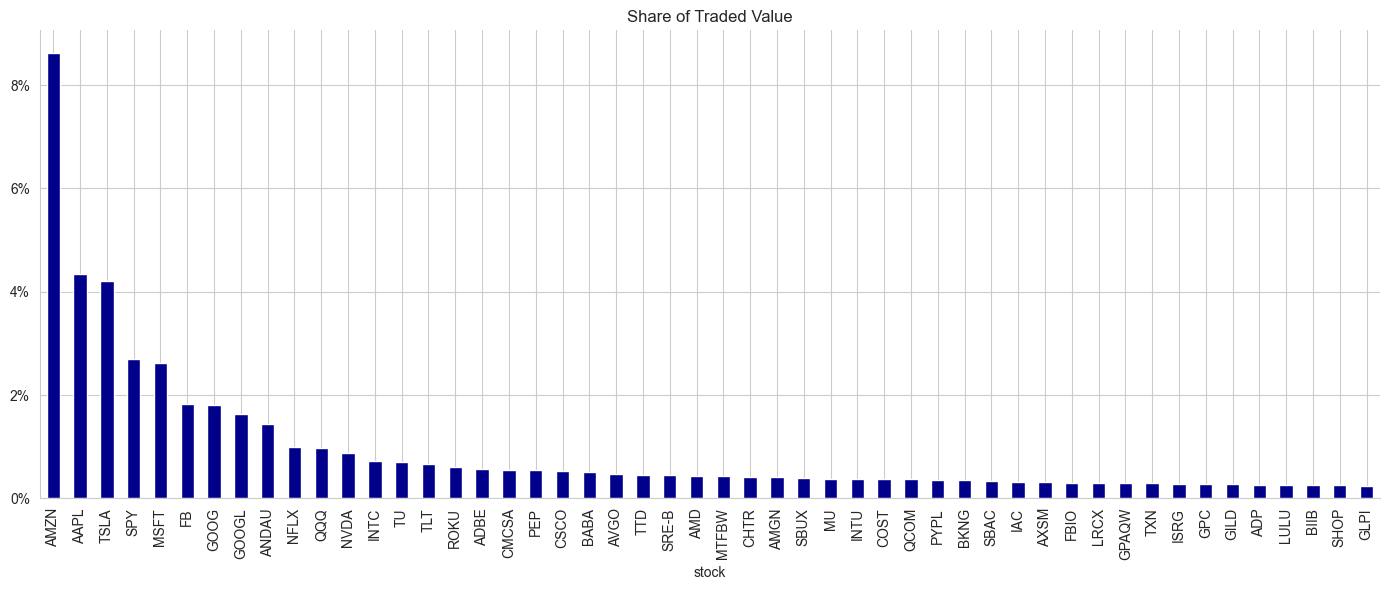

In [35]:
with pd.HDFStore(itch_store) as store:
    print(store.keys())
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    # Use pd.concat instead of append
    trades = pd.concat([store['P'], store['Q'].rename(columns={'cross_price': 'price'})], ignore_index=True, sort=False).merge(stocks, how='left')


trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()